In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import tensorflow as tf
from tensorflow.data import experimental
from matplotlib import gridspec
%matplotlib inline

In [ ]:
#run every session
#takes about 3 mins to run
drive.mount('/content/drive')
shared_folder_path = '/content/drive/MyDrive/DATASCI 207 Project/data'
file_path = os.path.join(shared_folder_path, 'LSWMD.pkl')
print(file_path)
df = pd.read_pickle(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DATASCI 207 Project/data/LSWMD.pkl


In [ ]:
#Renaming a column with a typo
df.rename(columns = {'trianTestLabel':'trainTestLabel'}, inplace = True)

#Function to extract string from a list or ndarray
def extract_string(x):
    if isinstance(x, list) and len(x) > 0:
        return x[0]
    elif isinstance(x, np.ndarray) and x.size > 0:
        return x.item(0)
    return x

#Applying the function to the dataframe
df['failureType'] = df['failureType'].apply(extract_string)
df['trainTestLabel'] = df['trainTestLabel'].apply(extract_string)

#Converting columns to string type
df['failureType'] = df['failureType'].astype(str)
df['trainTestLabel'] = df['trainTestLabel'].astype(str)

In [ ]:
df.head()

df.shape

(811457, 6)

In [ ]:
# Show the value counts for the 'failureType' column
df['failureType'].value_counts()

# Remove rows where 'failureType' is '[]' (unknown label)
df_clean_0 = df[df["failureType"]!="[]"]

Take out "[]" since it is a unkonwn label

In [ ]:
# Function to get dimensions of the wafer map
def get_dim(x):
    dim0 = np.size(x, axis=0)
    dim1 = np.size(x, axis=1)
    return dim0, dim1

In [ ]:
# Apply the function to get dimensions of each wafer map
df_clean_0['waferMapDim']= df_clean_0['waferMap'].apply(lambda x: get_dim(x))

# Show the value counts for the dimensions of the wafer maps
df_clean_0["waferMapDim"].value_counts().sort_values(ascending = False) #resize all to 50X50

<ipython-input-7-500f75c07fb4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_0['waferMapDim']= df_clean_0['waferMap'].apply(lambda x: get_dim(x))


waferMapDim
(25, 27)    18781
(26, 26)    14366
(30, 34)    12400
(29, 26)    11751
(27, 25)    10682
            ...  
(53, 71)        1
(41, 39)        1
(57, 39)        1
(50, 68)        1
(36, 41)        1
Name: count, Length: 346, dtype: int64

In [ ]:
df_clean_0.head()

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none,"(45, 48)"


In [ ]:
# Function to resize wafer maps to 50x50 pixels
def resize_wafer_map(wafer_map):
    wafer_map_np = np.array(wafer_map)
    resized_wafer_map = cv2.resize(wafer_map_np, (50, 50), interpolation=cv2.INTER_NEAREST)
    return resized_wafer_map

In [ ]:
# Apply the function to resize wafer maps
df_clean_0['resizedWaferMap'] = df_clean_0['waferMap'].apply(resize_wafer_map)


<ipython-input-10-b58fe3838eb4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_0['resizedWaferMap'] = df_clean_0['waferMap'].apply(resize_wafer_map)


In [ ]:
# Function to plot original and resized images
def plot_images(df, num_samples):
    samples = df.sample(n=num_samples, random_state=42)
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 2))

    for i, (idx, row) in enumerate(samples.iterrows()):
        original = np.array(row['waferMap'])
        resized = np.array(row['resizedWaferMap'])

        original_shape = original.shape

        axes[i, 0].imshow(original, cmap='gray')
        axes[i, 0].set_title(f'Original ({original_shape[0]}x{original_shape[1]})')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(resized, cmap='gray')
        axes[i, 1].set_title('Resized (50x50)')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

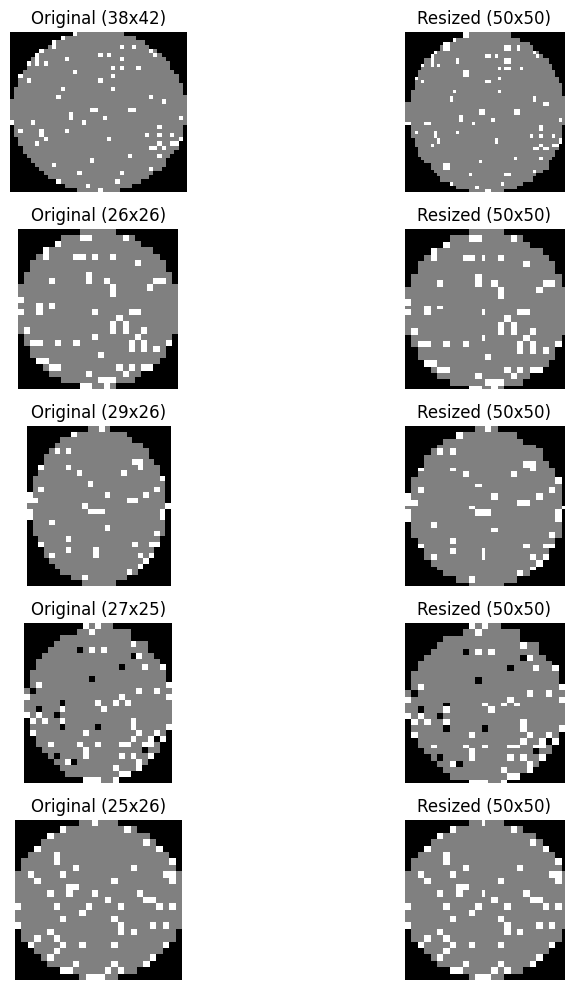

In [ ]:
# Plot a sample of 5 original and resized images
plot_images(df_clean_0, num_samples=5)


In [ ]:
# Verify that all resized wafer maps are 50x50
df_clean_0['resizeWaferMapDim']= df_clean_0['resizedWaferMap'].apply(lambda x: get_dim(x))

df_clean_0['resizeWaferMapDim'].value_counts()

<ipython-input-13-304bbe04c97e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_0['resizeWaferMapDim']= df_clean_0['resizedWaferMap'].apply(lambda x: get_dim(x))


resizeWaferMapDim
(50, 50)    172950
Name: count, dtype: int64

In [ ]:
# Show the value counts for 'failureType' column after cleaning
df_clean_0['failureType'].value_counts()

failureType
none         147431
Edge-Ring      9680
Edge-Loc       5189
Center         4294
Loc            3593
Scratch        1193
Random          866
Donut           555
Near-full       149
Name: count, dtype: int64

In [ ]:
# Calculate the proportion of the majority class 'none'. This would be the wafer with no issues
df_clean_0['failureType'].value_counts()[0]/df_clean_0['failureType'].value_counts().sum() #majority class "none" is 85% of data


0.8524486845909223

In [ ]:
# Encode 'failureType' labels as integers for modeling
label_mapping = {
    'Center': 1,
    'Donut': 2,
    'Edge-Loc': 3,
    'Edge-Ring': 4,
    'Loc': 5,
    'Near-full': 6,
    'Random': 7,
    'Scratch': 8,
    'none': 0
}

df_clean_0['encodedFailureType'] = df_clean_0['failureType'].replace(label_mapping) #encode label for CNN model

<ipython-input-16-4d3e31632594>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_0['encodedFailureType'] = df_clean_0['failureType'].replace(label_mapping) #encode label for CNN model


In [ ]:
# Function to reshape data to the required format for modeling
def reshape_data(data):
  reshaped_images = []
  for i in range(len(data)):
    reshaped_image = np.reshape(data[i], (50, 50))
    reshaped_images.append(reshaped_image)

  data = np.array(reshaped_images)
  data = data.reshape(-1, 50, 50, 1)
  return data

In [ ]:
tf.random.set_seed(1234)
np.random.seed(1234)

# Prepare features (X) and labels (Y)
X = df_clean_0['resizedWaferMap']
Y = df_clean_0['encodedFailureType']

# shuffle data
indx = np.arange(len(X))
np.random.shuffle(indx)
X = np.array(X)[indx]
Y= np.array(Y)[indx]

X_train, X_other, y_train, y_other = train_test_split(X, Y, test_size=0.4, random_state=1234)

X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.5, random_state=1234)

X_train = reshape_data(X_train)
X_val = reshape_data(X_val)
X_test = reshape_data(X_test)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (103770, 50, 50, 1)
y_train shape (103770,)
X_val shape (34590, 50, 50, 1)
y_val shape (34590,)
X_test shape (34590, 50, 50, 1)
y_test shape (34590,)


In [ ]:
# Baseline model: predict the majority class for all inputs
majority_class = 0
y_train_pred = [majority_class] * len(y_train)
y_val_pred = [majority_class] * len(y_val)

# Calculate accuracy for the baseline model
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)


print("Baseline Model")
print("Train Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))

Baseline Model
Train Accuracy: 85.09%
Validation Accuracy: 85.35%


In [ ]:
# Print the shape of one image and the total number of images
example_image_shape = X_train[0].shape
print("Shape of one image:", example_image_shape)
print("Number of Images:",X_train.shape)

Shape of one image: (50, 50, 1)
Number of Images: (103770, 50, 50, 1)


In [ ]:
# Print the class distribution in the training set
unique, frequency = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, frequency))
print("Class Distribution:", class_distribution)

Class Distribution: {0: 88302, 1: 2614, 2: 343, 3: 3189, 4: 5803, 5: 2162, 6: 96, 7: 517, 8: 744}


first undersampled the majority class "none" to 6000, and then augmented the other classes till they has 6000 images
I used 6000 because 5803 (class 4) was the most frequent class after the majority "none" class

All done below

In [ ]:
# Function to apply horizontal and vertical flips for data augmentation
def apply_all_flips(image):
    flips = [
        tf.image.flip_left_right(image),
        tf.image.flip_up_down(image),
        tf.image.flip_left_right(tf.image.flip_up_down(image))
    ]
    return flips

# Function to augment images by applying all flips
def augment_images(images):
    augmented_images = []
    for img in images:
        augmented_images.extend(apply_all_flips(img))  # Apply all flips
    return np.array(augmented_images)

In [ ]:
# Undersample the majority class 'none' to 5000 instances and keep all other classes
class_0_indices = np.where(y_train == 0)[0]
undersample_0_indices = np.random.choice(class_0_indices, 5000, replace=False)

other_class_indices = np.where(y_train != 0)[0]

new_indices = np.concatenate([undersample_0_indices, other_class_indices])
X_train_undersampled = X_train[new_indices]
y_train_undersampled = y_train[new_indices]

# Augment the undersampled data
X_train_augmented = []
y_train_augmented = []
visualization_images = []

for class_label in np.unique(y_train_undersampled):
    class_indices = np.where(y_train_undersampled == class_label)[0]
    class_images = X_train_undersampled[class_indices]

    if len(class_images) < 1000:
        augmented_images = augment_images(class_images)
        X_train_augmented.append(np.concatenate([class_images, augmented_images]))
        y_train_augmented.append(np.full(len(class_images) * 4, class_label))  # quadrupling the dataset

        visualization_images.append(augmented_images[:5])
    else:
        X_train_augmented.append(class_images)
        y_train_augmented.append(np.full(len(class_images), class_label))

X_train_final = np.concatenate(X_train_augmented)
y_train_final = np.concatenate(y_train_augmented)

# Print the final class distribution after augmentation
final_class_distribution = dict(zip(*np.unique(y_train_final, return_counts=True)))
print("Final class distribution:", final_class_distribution)

Final class distribution: {0: 5000, 1: 2614, 2: 1372, 3: 3189, 4: 5803, 5: 2162, 6: 384, 7: 2068, 8: 2976}


Final class distribution: {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000}


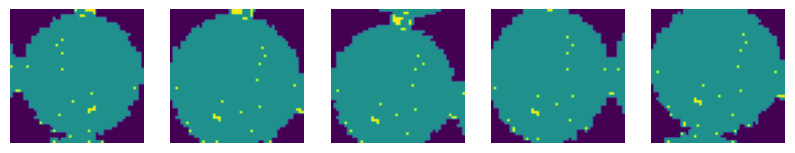

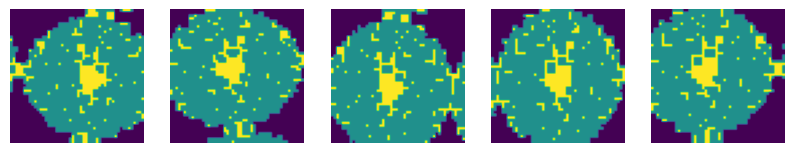

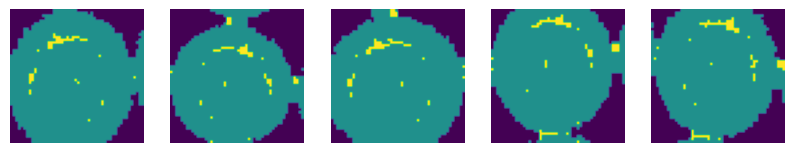

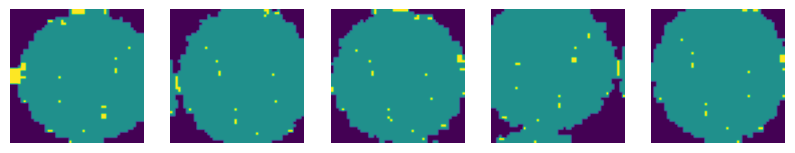

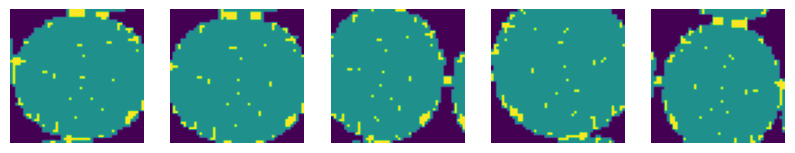

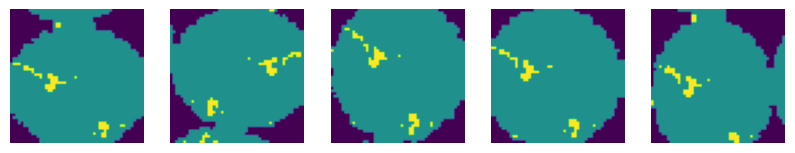

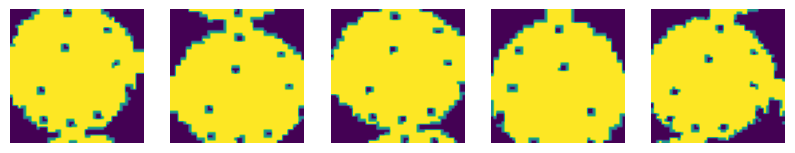

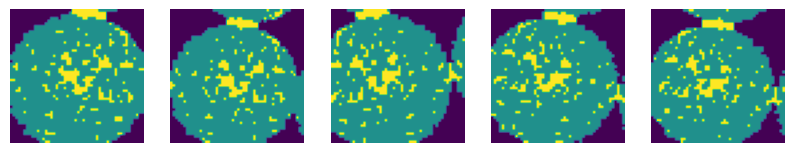

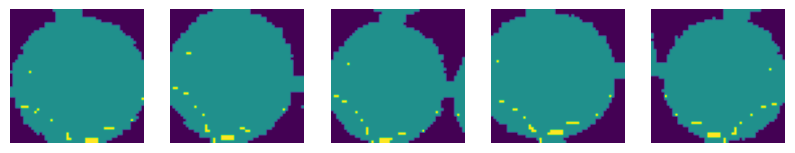

In [ ]:
# Configure image data generator for more data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,        # Reduced rotation range
    width_shift_range=0.1,    # Reduced width shift
    height_shift_range=0.1,   # Reduced height shift
    shear_range=0.1,          # Reduced shear range
    zoom_range=0.1,           # Reduced zoom range
    horizontal_flip=True,     # Enable horizontal flipping
    fill_mode='reflect'       # Handle newly created pixels
)

# Function to augment images until we reach the target number per class
def augment_images_to_target(images, target_num):
    augmented_images = []
    for img in images:
        img = np.expand_dims(img, 0)
        count = 0
        for batch in datagen.flow(img, batch_size=1):
            augmented_images.append(batch[0])
            count += 1
            if len(images) + count >= target_num:
                break
        if len(images) + len(augmented_images) >= target_num:
            break
    return np.array(augmented_images[:target_num - len(images)])

# Undersample class 0 to 5000 instances
class_0_indices = np.where(y_train == 0)[0]
undersample_0_indices = np.random.choice(class_0_indices, 5000, replace=False)

# Keep all instances of other classes
other_class_indices = np.where(y_train != 0)[0]

# Combine undersampled class 0 indices with other class indices
new_indices = np.concatenate([undersample_0_indices, other_class_indices])
X_train_undersampled = X_train[new_indices]
y_train_undersampled = y_train[new_indices]

# Augment images and ensure each class has 6000 images
X_train_augmented = []
y_train_augmented = []
visualization_images = []

for class_label in np.unique(y_train_undersampled):
    class_indices = np.where(y_train_undersampled == class_label)[0]
    class_images = X_train_undersampled[class_indices]

    if len(class_images) < 6000:
        # Augment the images until we reach 6000 images per class
        augmented_images = augment_images_to_target(class_images, 6000)
        X_train_augmented.append(np.concatenate([class_images, augmented_images]))
        y_train_augmented.append(np.full(6000, class_label))

        visualization_images.append(augmented_images[:5])
    else:
        X_train_augmented.append(class_images[:6000])
        y_train_augmented.append(np.full(6000, class_label))

X_train_final = np.concatenate(X_train_augmented)
y_train_final = np.concatenate(y_train_augmented)

# Print the final class distribution after augmentation
final_class_distribution = dict(zip(*np.unique(y_train_final, return_counts=True)))
print("Final class distribution:", final_class_distribution)

# Visualize some augmented images
import matplotlib.pyplot as plt

for i, class_images in enumerate(visualization_images):
    plt.figure(figsize=(10, 10))
    for j in range(len(class_images)):
        plt.subplot(1, 5, j + 1)
        plt.imshow(class_images[j].astype('uint8'))
        plt.axis('off')
    plt.show()

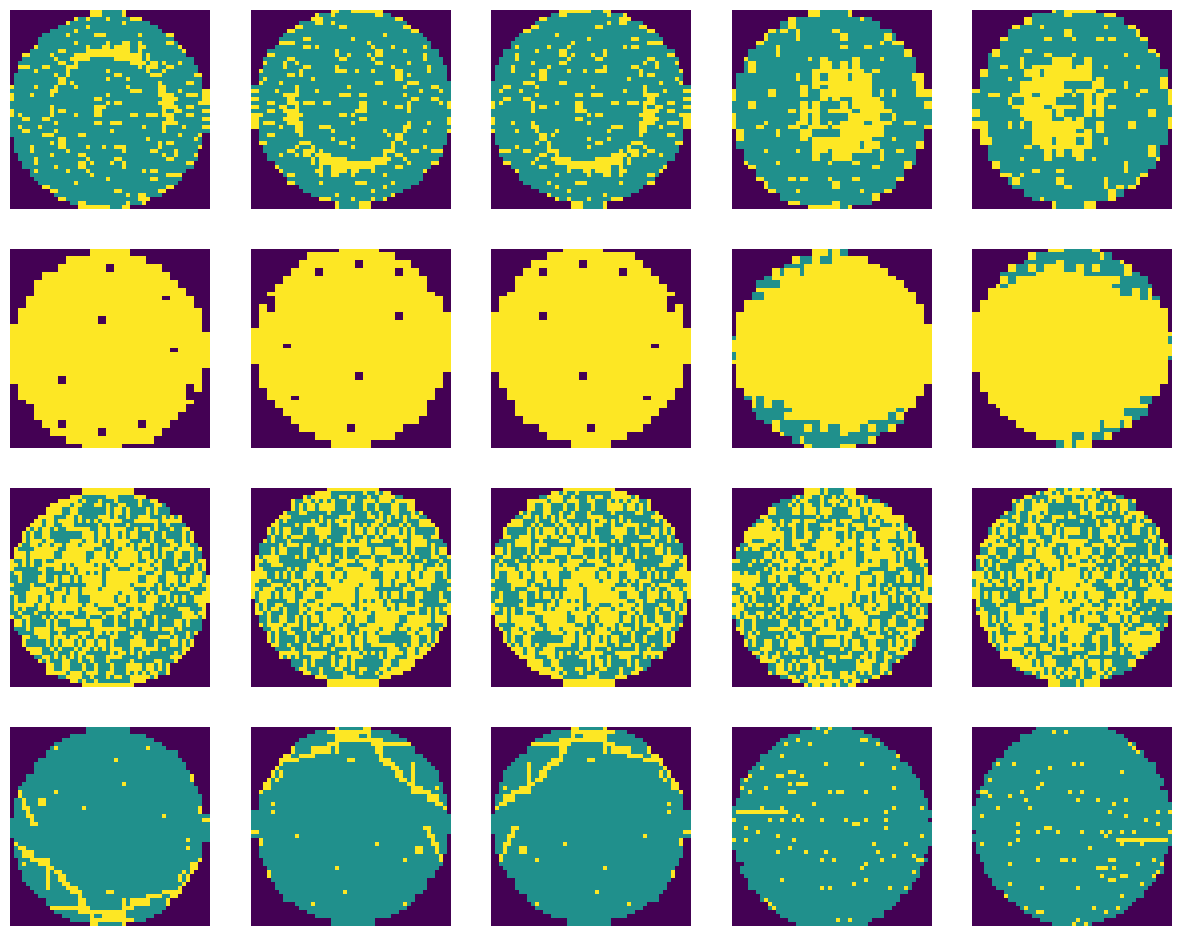

In [ ]:
# Combine all visualization images into one array
visualization_images = np.concatenate(visualization_images)
num_images = len(visualization_images)

# Plot a sample of 25 augmented images
plt.figure(figsize=(15, 15))
for i in range(min(num_images, 25)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(visualization_images[i].astype('uint8'))
    plt.axis('off')
plt.show()

In [ ]:
# Normalize the final training, validation, and test datasets
X_train_final = X_train_final / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [ ]:
X_train_final.shape

(25568, 50, 50, 1)

In [ ]:

y_train_final.shape

(25568,)

In [ ]:
y_val.shape

(34590,)

In [ ]:
X_val

dtype('float64')

In [ ]:

num_classes = 9  # Number of unique classes (0-8)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_final, y_train_final,
                    epochs=5,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=1)

val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 11, 11, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 4, 4, 128)        